## Training Autoencoders
This notebook demonstrates the usage of autoencoders. In the following, we train an autoencoder with convolutional layers to map handwritten digits from the MNIST dataset into a lower dimensional latent representation. We then demonstrate how one can generate new images by interpolating in the latent space.

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(1312)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
x2 = torch.randn(20,3,16,16)
convt = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=5, stride=2, padding=2)
print(convt(x2).shape)

torch.Size([20, 1, 31, 31])


# Data
Since we are already familiar with the MNIST dataset, we just load it here. Note however that this is an unsupervised setup, so there is no validation and no labels here, only raw images.

In [64]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:2**15] # len(mnist_data)=60000

train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

In [65]:
print(train_loader.dataset[0][0].shape, train_loader.dataset[0][1])

torch.Size([1, 28, 28]) 5


# Model
The autoencoder we are interested in implementing is based on the one illustrated below (with some **difference** in the sizes of the convlutions).
Therefore, before going into the model itself, let us first describe the *DeConv* layers which carry out dimensionality increasing convlutional operations, also known as *Convolution Transpose*.



![picture](https://drive.google.com/uc?id=1pGK0fc-jbD4nDUlhePm435ynAibB5hbW)

## Convolution Transpose

Convlution transpose layers implement a linear mapping which can be viewed as an inverse of covolution layers. In practice, these layers just implement convlution with zero-padding between the pixels of the input image, thus generating a higher-dimensional image.

The padding is effectively set so that when a `Conv2d` and a `ConvTranspose2d` are initialized with **same parameters** (i.e, kernel_size), they are inverses of each other in regard to the input and output shapes

Let's see how they work, by just passing a tensor through an untrained convolutional layer

In [66]:
conv = nn.Conv2d(in_channels=1,
                 out_channels=1,
                 kernel_size=3, bias=False)

x = torch.ones(1, 1, 5, 5)
conv.weight = torch.nn.Parameter(torch.ones(1, 1, 3, 3))
y = conv(x)
print(f'input is \n {x.numpy()}, \n kernel is \n {conv.weight.detach().numpy()},\n output is \n {y.detach().numpy()}')

input is 
 [[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]]]], 
 kernel is 
 [[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]],
 output is 
 [[[[9. 9. 9.]
   [9. 9. 9.]
   [9. 9. 9.]]]]


As expected, the output size (for either height or width) is given by:
$$\text{output_size}=\text{input_size}-\text{kernel_size}+1.$$
Now the convolutional transpose layer should return the output $y$ back to its original shape, using padding, i.e.,
$$\text{output_size} + 2\times \text{padding}-\text{kernel_size}+1=\text{input_size}.$$
That is,
$$\text{padding} = \frac{\text{input_size}-\text{output_size}+\text{kernel_size}-1}{2} $$
$$\text{padding}=
\frac{\text{input_size}-\text{input_size}+\text{kernel_size}-1+\text{kernel_size}-1}{2}$$
$$\text{padding}=\frac{2\times\text{kernel_size}-2}{2}=\text{kernel_size}-1.$$
Therefore, in our example, $\text{padding} = 2$.

In [67]:
convt = nn.ConvTranspose2d(in_channels=1,
                           out_channels=1,
                           kernel_size=3, bias=False)
convt.weight = torch.nn.Parameter(torch.ones(1, 1, 3, 3))
yy = convt(y)
padded_y = F.pad(y,(2,2,2,2))
print(f'convt kernel is \n {convt.weight.detach().numpy()}, \n padded y is \n {padded_y.detach().numpy()}\n convt output is \n {yy.detach().numpy()}')

convt kernel is 
 [[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]], 
 padded y is 
 [[[[0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 9. 9. 9. 0. 0.]
   [0. 0. 9. 9. 9. 0. 0.]
   [0. 0. 9. 9. 9. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0.]]]]
 convt output is 
 [[[[ 9. 18. 27. 18.  9.]
   [18. 36. 54. 36. 18.]
   [27. 54. 81. 54. 27.]
   [18. 36. 54. 36. 18.]
   [ 9. 18. 27. 18.  9.]]]]


So the output dimensionality is indeed as that of the convolutional layer input.

A nice visualization of how transposed convolutions (compared to standard convolutions) operate can be found in [this link](https://github.com/vdumoulin/conv_arithmetic).

## Autoencoder

The autoencoder we are implementing is comprised solely of convolutions (as learned, these are highly useful once images as considered). Therefore, its dimensionality reduction is obtained from the usage of stride that is larger than one.

We divide its compoenents into an encoder and a decoder, so that we can later use each compoenent seperately, thus carrying out manipulations in the latent space (which here is merely a $64\times 1$ vector, compared to the input which has $28^2=784$ entries). To see this we note that the dimensions of the matrices at each layer are:
\begin{align}
H_0 = W_0 &= 28, \\
H_1 = W_1 &= \left\lfloor\frac{H_0(=28)+2P_1(=1)-F_1(=3)}{S_1(=2)}\right\rfloor +1 = 14, \\
H_2 = W_2 &= \left\lfloor\frac{H_1(=14)+2P_2(=1)-F_2(=3)}{S_2(=2)}\right\rfloor +1 = 7, \\
H_3 = W_3 &= \left\lfloor\frac{H_2(=7)+2P_3(=0)-F_3(=7)}{S_3(=1)}\right\rfloor +1 = 1.
\end{align}

* Note that the original input_size for a transposed conv layer is ambiguious because output_size involves floor function. To mitiagate that, `output_padding` parameter is used. That is, set `output_padding` to be the modulo of the floor operation.
* To guarantee that the output indeed takes values in the range $[0,1]$ (as does the input), we use a sigmoid output layer

In [68]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Training
Now, we can train the network.

## Training function

To define the training function, let us recall that the objective of the autoencoder is to map its output back to its input. Therefore, we use the MSE loss, applied to the input and the output.

Note that there is no validation here, so we are only evaluating the training loss. Nonetheless, we are saving the outputs at each iteration to view later.

In [69]:
criterion = nn.MSELoss()

def train(model, num_epochs=5, learning_rate=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data
            recon = model(img)
            loss = criterion(recon, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon))
    return outputs

In [70]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0152
Epoch:2, Loss:0.0072
Epoch:3, Loss:0.0056
Epoch:4, Loss:0.0045
Epoch:5, Loss:0.0038
Epoch:6, Loss:0.0043
Epoch:7, Loss:0.0034
Epoch:8, Loss:0.0036
Epoch:9, Loss:0.0032
Epoch:10, Loss:0.0030
Epoch:11, Loss:0.0031
Epoch:12, Loss:0.0028
Epoch:13, Loss:0.0027
Epoch:14, Loss:0.0031
Epoch:15, Loss:0.0032
Epoch:16, Loss:0.0030
Epoch:17, Loss:0.0033
Epoch:18, Loss:0.0029
Epoch:19, Loss:0.0029
Epoch:20, Loss:0.0029


In [71]:
outputs[0][2].shape

torch.Size([64, 1, 28, 28])

## Visualize the training
Since we have saved the outputs, we can visualize the training progress, by comparing the inputs to their outputs over gaps of five epochs.

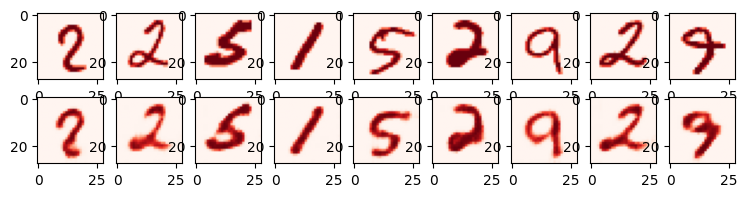

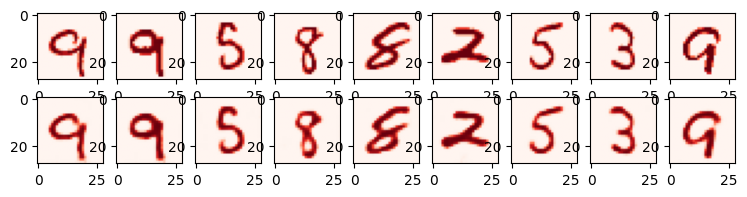

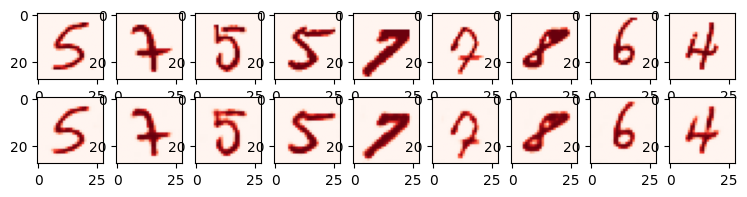

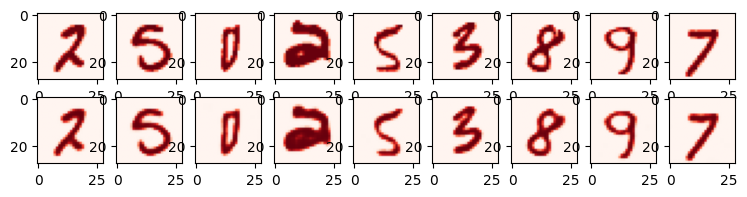

In [72]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0], cmap="Reds")

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0], cmap="Reds")

# Interpolating in the Latent Space

Since we are drastically reducing the dimensionality of the image, there has to be some kind of structure in the latent space. That is, the network should be able to "save" space by mapping similar images to similar latent vectors.

We will demonstrate the structure of the latent space. Let's begin with two images in our training set. For now, we'll choose images of the same digit.

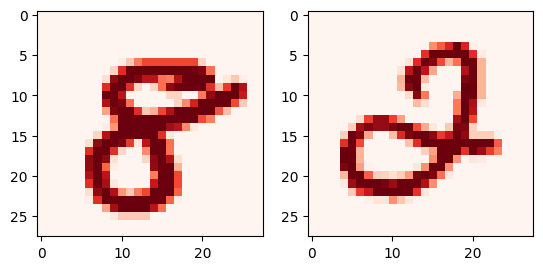

In [73]:
imgs = outputs[max_epochs-1][1].detach().numpy() # imgs.shape=(64, 1, 28, 28)
plt.subplot(1, 2, 1)
plt.imshow(imgs[8].squeeze(0), cmap="Reds") # remove the channel dimension
plt.subplot(1, 2, 2)
plt.imshow(imgs[9].squeeze(0), cmap="Reds")


We will then compute the low-dimensional embeddings of both images, by applying the encoder:

In [74]:
x1 = outputs[max_epochs-1][1][8,:,:,:] # first image
x2 = outputs[max_epochs-1][1][9,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once. torch.stack concatenates a sequence of tensors along a new dimension (default dim=0)
print(x.shape)
latent = model.encoder(x)
z1 = latent[0] # latent of first image
z2 = latent[1] # latent of second image

z1.shape

torch.Size([2, 1, 28, 28])


torch.Size([64, 1, 1])

Now we will do something interesting. Not only are we goign to run the decoder on those two embeddings `z1` and `z2`, we are also going to interpolate between the two embeddings and decode those as well!

In [75]:
latent_values = []
for i in range(0, 10):
    z = z1 * (i/10) + z2 * (10-i)/10
    latent_values.append(z)
latent_values = torch.stack(latent_values)

recons = model.decoder(latent_values)

Let's plot the reconstructions of each interpolated values. The original images are shown below too:

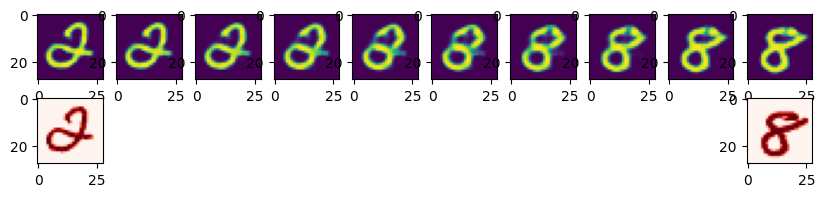

In [76]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[9][0], cmap="Reds")
plt.subplot(2,10,20)
plt.imshow(imgs[8][0], cmap="Reds")


Notice that there is a smooth transition between the two images. The middle images are likely new, in that there are no training images that are exactly like any of the generated images.

We can do the same thing with two images containing different digits. There should be a smooth transition between the two digits

In [77]:
def interpolate(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]
    x = torch.stack([x1,x2])
    latent = model.encoder(x)
    z1 = latent[0] # latent of first image
    z2 = latent[1] # latent of second image


    latent_values = []
    for i in range(0, 10):
        z = z1 * (i/10) + z2 * (10-i)/10
        latent_values.append(z)
    latent_values = torch.stack(latent_values)

    recons = model.decoder(latent_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0], cmap="Reds")
    plt.subplot(2,10,11)
    plt.imshow(x2[0], cmap="Reds")
    plt.subplot(2,10,20)
    plt.imshow(x1[0], cmap="Reds")

Let's visualize some interpolations in the latent space:

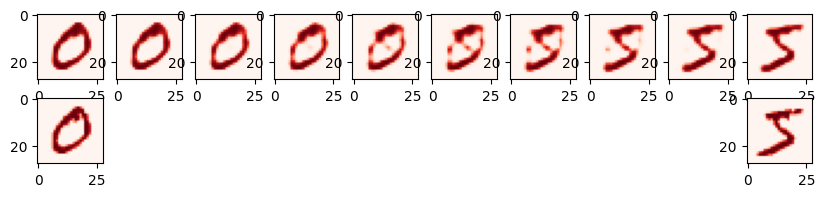

In [78]:
interpolate(0, 1)

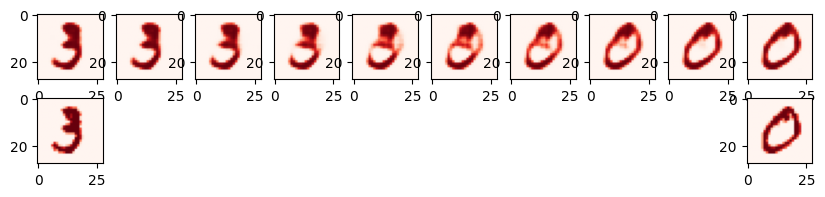

In [79]:
interpolate(1, 10)

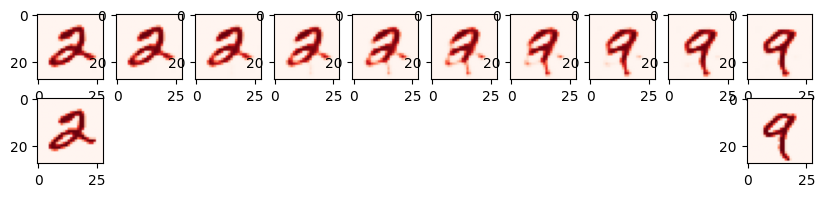

In [80]:
interpolate(4, 5)

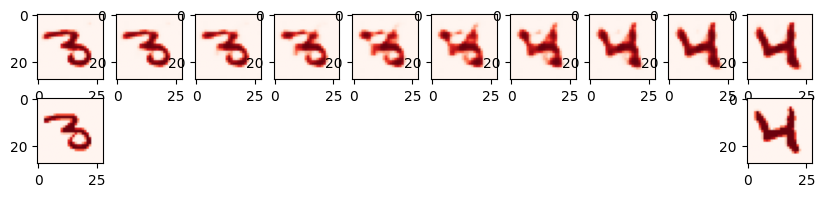

In [81]:
interpolate(20, 30)

## Are the Latents Similar?
As we can see from the interpolated examples, the learn latent space is somewhat "smooth". This raises a question: does the autoencoder learns similar representations for the same digits?

In [82]:
all_latents = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        # Ensure images are on the correct device if model is on CUDA
        images = images.to(device) # Add this line if 'device' is used for model
        latent = model.encoder(images)
        all_latents.append(latent.cpu()) # Move to CPU for easier concatenation/storage
        all_labels.append(labels)

all_latents_tensor = torch.cat(all_latents, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

print(f"Shape of all latent representations: {all_latents_tensor.shape}")
print(f"Shape of all labels: {all_labels_tensor.shape}")

Shape of all latent representations: torch.Size([32768, 64, 1, 1])
Shape of all labels: torch.Size([32768])


### Compute Pairwise Cosine Similarities

Combine all extracted latent vectors and compute the cosine similarity between each pair of these vectors. Reshape the `all_latents_tensor` to a 2D tensor, normalize each latent vector, and then compute the pairwise cosine similarity matrix.



In [83]:
latent_vectors_2d = all_latents_tensor.squeeze()
normalized_latent_vectors = torch.nn.functional.normalize(latent_vectors_2d, p=2, dim=1)
cosine_similarity_matrix = torch.matmul(normalized_latent_vectors, normalized_latent_vectors.T)

print(f"Shape of 2D latent vectors: {latent_vectors_2d.shape}")
print(f"Shape of normalized latent vectors: {normalized_latent_vectors.shape}")
print(f"Shape of cosine similarity matrix: {cosine_similarity_matrix.shape}")

Shape of 2D latent vectors: torch.Size([32768, 64])
Shape of normalized latent vectors: torch.Size([32768, 64])
Shape of cosine similarity matrix: torch.Size([32768, 32768])


### Aggregate Similarities by Class

Group the cosine similarity results based on the original digit classes. Calculate the average cosine similarity between all pairs of samples belonging to each combination of classes (e.g., average similarity between all '0's and all '1's, all '0's and all '0's, etc.).


In [84]:
# Initialize an empty 10x10 NumPy array to store average similarities
average_similarity_matrix = np.zeros((10, 10))

# Iterate through each digit class i (rows)
for i in range(10):
    # Get indices of samples belonging to class i
    indices_i = (all_labels_tensor == i).nonzero(as_tuple=True)[0]

    # Iterate through each digit class j (columns)
    for j in range(10):
        # Get indices of samples belonging to class j
        indices_j = (all_labels_tensor == j).nonzero(as_tuple=True)[0]

        if len(indices_i) > 0 and len(indices_j) > 0:
            # Extract the sub-matrix of similarities between class i and class j
            sub_matrix = cosine_similarity_matrix[indices_i[:, None], indices_j]

            # Calculate the mean of this sub-matrix
            average_similarity = sub_matrix.mean().item()
        else:
            # Handle cases where there are no samples for a class
            average_similarity = 0.0 # Assign 0 or NaN as per instructions

        # Store the average similarity in the result matrix
        average_similarity_matrix[i, j] = average_similarity


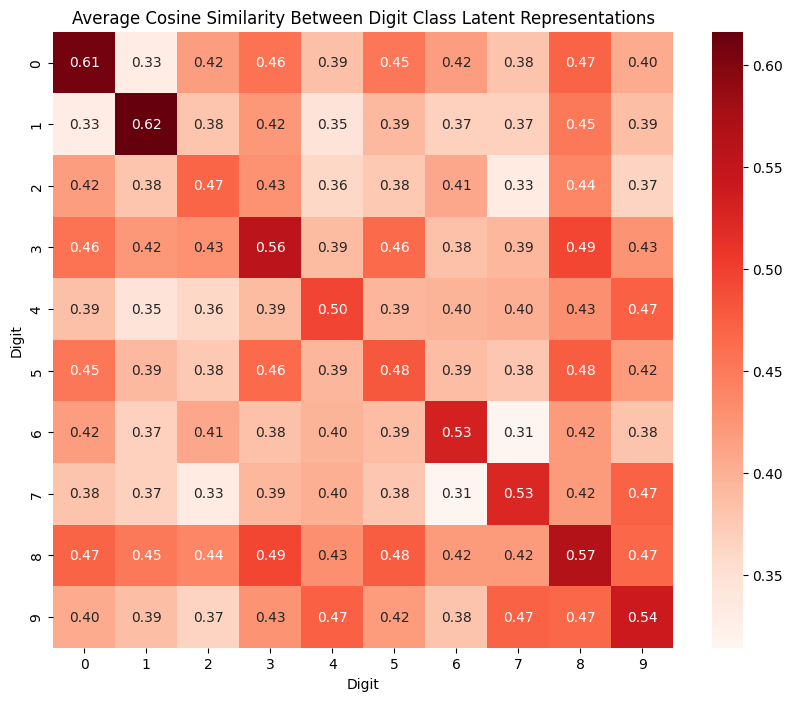

In [85]:
plt.figure(figsize=(10, 8))
sns.heatmap(average_similarity_matrix, annot=True, cmap='Reds', fmt=".2f",
            xticklabels=range(10), yticklabels=range(10))
plt.title('Average Cosine Similarity Between Digit Class Latent Representations')
plt.xlabel('Digit')
plt.ylabel('Digit')
plt.show()